In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [54]:
ambient_data = pd.read_excel("../resources/aap_bod_may2018_v0.xlsx", sheet_name=1)
household_data = pd.read_excel("../resources/hap_bod_may2018_v0.xlsx", sheet_name=1)
joint_data = pd.read_excel("../resources/ap_bod_may2018_v0.xlsx", sheet_name=1)

In [3]:
# define functions
def categorize_features(df, features, dummies=False):
    df_copy = df.copy()
    categories = {}
    for feature in features:
        df_copy[feature] = pd.Categorical(df_copy[feature])
        df_copy['{}_code'.format(feature)] = df_copy[feature].cat.codes
        categories.update({feature: list(df_copy[feature].cat.categories)})
        
    return df_copy.drop(features, axis=1), categories

def normalize_data(df, features):
    df_copy = df.copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_copy[features])
    df_copy[features] = scaled
    return df_copy

def make_dummy_variables(df, features):
    df_copy = df.copy()
    dummies = pd.get_dummies(df_copy[features])
    df_copy = pd.concat([df_copy, dummies], axis=1)
    return df_copy.drop(features, axis=1)

In [4]:
display(ambient_data.head())
display(household_data.head())
display(joint_data.head())

,iso3,whoname,year,causename2,cause2015,sex,age,health_outcome,AB_AAP_mean,AB_AAP_lower,AB_AAP_upper,AB_AAP_pc_mean,AB_AAP_pc_upper,AB_AAP_pc_lower,AB_AAP_pc_mean_AS,AB_AAP_pc_upper_AS,AB_AAP_pc_lower_AS,status
0,AFG,Afghanistan,2016,ALRI,390,b,0,dths,4245.812988,3289.411133,5218.406250,12.251298,15.057716,9.491599,7.160412,8.800656,5.547474,NaN
1,AFG,Afghanistan,2016,Lung cancer,680,b,25+,dths,245.479962,160.320648,333.016693,0.708333,0.960920,0.462605,1.780666,2.415641,1.162936,NaN
2,AFG,Afghanistan,2016,IHD,1130,b,25+,dths,7271.271439,6228.604980,8333.379883,20.981260,24.045977,17.972647,58.344009,66.866272,49.977753,NaN
3,AFG,Afghanistan,2016,Stroke,1140,b,25+,dths,2743.734619,2329.802002,3185.718750,7.917049,9.192394,6.722646,22.796988,26.469320,19.357727,NaN
4,AFG,Afghanistan,2016,COPD,1180,b,25+,dths,1243.574786,750.883606,1776.479858,3.588336,5.126034,2.166675,12.026935,17.180798,7.261990,NaN


,iso3,whoname,year,causename2,cause2015,sex,age,health_outcome,AB_HAP_mean,AB_HAP_lower,AB_HAP_upper,AB_HAP_pc_mean_AS,AB_HAP_pc_upper_AS,AB_HAP_pc_lower_AS,AB_HAP_pc_mean,AB_HAP_pc_upper,AB_HAP_pc_lower,status
0,AFG,Afghanistan,2016,All diseases,10000,m,All ages (AP),dths,10678.351624,8731.171875,12546.909180,139.355408,163.740601,113.944176,59.774410,70.234070,48.874645,NaN
1,AFG,Afghanistan,2016,All diseases,10000,b,All ages (AP),dths,21140.724251,17399.779297,24672.519531,132.584839,154.734634,109.123367,61.001579,71.192581,50.207081,NaN
2,AFG,Afghanistan,2016,All diseases,10000,f,All ages (AP),dths,10462.372454,8624.180664,12100.211914,126.241425,146.003983,104.061371,62.307156,72.061073,51.360065,NaN
3,AFG,Afghanistan,2016,IHD,1130,m,25+,dths,4369.218437,3453.360596,5312.166992,69.285500,84.238441,54.762154,24.457657,29.736017,19.330942,NaN
4,AFG,Afghanistan,2016,IHD,1130,b,25+,dths,7898.803864,6275.023438,9483.331055,63.137405,75.802986,50.158066,22.792006,27.364161,18.106586,NaN


,iso3,whoname,year,causename2,cause2015,sex,age,health_outcome,AB_joint_mean,AB_joint_upper,AB_joint_lower,AB_joint_pc_mean,AB_joint_pc_upper,AB_joint_pc_lower,AB_joint_pc_mean_AS,AB_joint_pc_upper_AS,AB_joint_pc_lower_AS,status
0,AFG,Afghanistan,2016,All diseases,10000,m,All ages (AP),dths,16760.236328,18932.732422,15273.503906,95.580666,105.980110,85.496780,228.704529,253.588226,204.575897,NaN
1,AFG,Afghanistan,2016,All diseases,10000,b,All ages (AP),dths,32338.224609,36131.609375,29500.552734,95.115097,104.257797,85.123871,211.051498,231.338272,188.881912,NaN
2,AFG,Afghanistan,2016,All diseases,10000,f,All ages (AP),dths,15577.987305,17445.390625,14197.558594,94.630722,103.893517,84.551521,194.663910,213.718307,173.930069,NaN
3,AFG,Afghanistan,2016,IHD,1130,m,25+,dths,7430.208496,8634.837891,6458.652344,42.230488,48.335396,36.153721,120.239014,137.620956,102.937187,NaN
4,AFG,Afghanistan,2016,IHD,1130,b,25+,dths,13146.098633,15125.824219,11479.080078,38.512386,43.645580,33.122898,106.865128,121.108841,91.910233,NaN


In [5]:
ambient_data.describe()

,year,cause2015,AB_AAP_mean,AB_AAP_lower,AB_AAP_upper,AB_AAP_pc_mean,AB_AAP_pc_upper,AB_AAP_pc_lower,AB_AAP_pc_mean_AS,AB_AAP_pc_upper_AS,AB_AAP_pc_lower_AS,status
count,8536.0,8536.000000,8.074000e+03,8.074000e+03,8.074000e+03,8074.000000,8074.000000,8074.000000,8074.000000,8074.000000,8074.000000,176.0
mean,2016.0,2080.454545,6.883357e+04,5.501257e+04,8.387137e+04,196.729042,250.100410,148.862966,200.780597,251.899594,154.480476,1.0
std,0.0,3162.935054,6.857521e+05,5.915423e+05,7.876918e+05,460.370953,563.811604,366.314579,463.413739,559.622144,376.360452,0.0
min,2016.0,390.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2016.0,390.000000,9.981248e+01,5.315775e+01,1.541849e+02,3.645946,5.777400,1.913657,3.808844,5.932510,1.940153,1.0
50%,2016.0,1130.000000,1.053548e+03,6.677233e+02,1.531985e+03,22.199898,30.814934,14.006332,23.172267,32.152597,15.286150,1.0
75%,2016.0,1180.000000,1.027784e+04,6.873427e+03,1.405386e+04,137.778374,197.395462,89.977613,151.973618,219.095695,97.809050,1.0
max,2016.0,10000.000000,3.372782e+07,2.997548e+07,3.789344e+07,5598.220703,6765.243164,4514.689941,5304.012695,6409.703613,4277.425781,1.0


In [6]:
household_data.describe()

,year,cause2015,AB_HAP_mean,AB_HAP_lower,AB_HAP_upper,AB_HAP_pc_mean_AS,AB_HAP_pc_upper_AS,AB_HAP_pc_lower_AS,AB_HAP_pc_mean,AB_HAP_pc_upper,AB_HAP_pc_lower,status
count,8536.0,8536.000000,7.920000e+03,7.920000e+03,7.920000e+03,7920.000000,6666.000000,6666.000000,7920.000000,7920.000000,7920.000000,176.0
mean,2016.0,2080.454545,7.527237e+04,5.109182e+04,9.930229e+04,258.335658,396.964991,224.878544,247.308422,323.734117,179.112076,1.0
std,0.0,3162.935054,7.084272e+05,4.751308e+05,9.312272e+05,760.024512,960.050768,656.788903,780.152994,921.294022,617.043812,0.0
min,2016.0,390.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2016.0,390.000000,8.793654e+00,8.546308e-02,2.105435e+01,0.575635,8.333909,0.220118,0.469509,1.235273,0.004043,1.0
50%,2016.0,1130.000000,4.144561e+02,6.587317e+01,8.748312e+02,13.078442,41.915045,7.803701,10.547303,19.104506,2.259911,1.0
75%,2016.0,1180.000000,5.571440e+03,2.370630e+03,1.002986e+04,102.231005,287.292793,84.905867,78.115999,147.342525,34.208024,1.0
max,2016.0,10000.000000,3.453418e+07,2.480558e+07,4.292519e+07,8384.670898,9530.670898,7128.576660,9220.375000,10543.326172,7410.398926,1.0


In [7]:
joint_data.describe()

,year,cause2015,AB_joint_mean,AB_joint_upper,AB_joint_lower,AB_joint_pc_mean,AB_joint_pc_upper,AB_joint_pc_lower,AB_joint_pc_mean_AS,AB_joint_pc_upper_AS,AB_joint_pc_lower_AS,status
count,8536.0,8536.000000,8.250000e+03,8.052000e+03,8.052000e+03,8049.000000,8049.000000,8049.000000,8250.000000,8052.000000,8052.000000,176.0
mean,2016.0,2080.454545,1.199764e+05,1.466592e+05,1.002993e+05,386.953182,463.689846,315.223771,391.297804,475.228145,329.747195,1.0
std,0.0,3162.935054,1.158145e+06,1.379202e+06,9.789335e+05,1002.876569,1139.093741,856.079567,993.444026,1132.272972,865.376494,0.0
min,2016.0,390.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2016.0,390.000000,1.791725e+02,3.284530e+02,1.246382e+02,7.397463,11.070452,4.429657,6.284539,11.097624,4.288564,1.0
50%,2016.0,1130.000000,1.852235e+03,2.836188e+03,1.354081e+03,38.458794,52.149048,25.817434,41.047892,59.866386,30.020609,1.0
75%,2016.0,1180.000000,1.629323e+04,2.304223e+04,1.245220e+04,232.803925,306.510406,158.189804,237.717529,337.884911,187.814037,1.0
max,2016.0,10000.000000,5.702102e+07,6.493796e+07,5.006718e+07,11944.154297,13200.084961,10356.625977,11122.824219,12292.392578,9644.460938,1.0


In [8]:
# drop year, status, cause2015  columns
ambient_data = ambient_data.drop(['year', 'status', 'cause2015', 'whoname'], axis=1)
household_data = household_data.drop(['year', 'status', 'cause2015', 'whoname'], axis=1)
joint_data = joint_data.drop(['year', 'status', 'cause2015', 'whoname'], axis=1)

In [9]:
ambient_data.isna().sum()

iso3                    0
causename2              0
sex                     0
age                     0
health_outcome          0
AB_AAP_mean           462
AB_AAP_lower          462
AB_AAP_upper          462
AB_AAP_pc_mean        462
AB_AAP_pc_upper       462
AB_AAP_pc_lower       462
AB_AAP_pc_mean_AS     462
AB_AAP_pc_upper_AS    462
AB_AAP_pc_lower_AS    462
dtype: int64

In [10]:
grouped = household_data.groupby('iso3').apply(lambda x :x.isna().sum())
countries_to_remove = list(grouped[grouped['AB_HAP_pc_upper_AS']>0].index)

grouped_2 = ambient_data.groupby('iso3').apply(lambda x :x.isna().sum())
countries_to_remove_2 = list(grouped_2[grouped_2['AB_AAP_pc_upper_AS']>0].index)

grouped_3 = joint_data.groupby('iso3').apply(lambda x :x.isna().sum())
countries_to_remove_3 = list(grouped_3[grouped_3['AB_joint_pc_upper_AS']>0].index)

In [11]:
countries_to_remove = set(countries_to_remove + countries_to_remove_2 + countries_to_remove_3)

In [12]:
# drop countries that dont have the numerical data
ambient_data = ambient_data.loc[~ambient_data['iso3'].isin(countries_to_remove)]
household_data = household_data.loc[~household_data['iso3'].isin(countries_to_remove)]
joint_data = joint_data.loc[~joint_data['iso3'].isin(countries_to_remove)]

In [13]:
# make the AB columns name the same for the three datasets
rename_ambient = {column :'_'.join(column.split('_')[2:]) for column in ambient_data.iloc[:, 5:].columns}
rename_household = {column: '_'.join(column.split('_')[2:]) for column in household_data.iloc[:, 5:].columns}
rename_joint = {column: '_'.join(column.split('_')[2:]) for column in joint_data.iloc[:, 5:].columns}

ambient_data = ambient_data.rename(rename_ambient, axis=1)
household_data = household_data.rename(rename_household, axis=1)
joint_data = joint_data.rename(rename_joint, axis=1)

In [14]:
# create the feature 'dataset' to merge the datasets. 0 - ambient, 1-household, 2-joint
ambient_data['dataset'] = [0 for x in range(len(ambient_data))]
household_data['dataset'] = [1 for x in range(len(household_data))]
joint_data['dataset'] = [2 for x in range(len(joint_data))]

In [15]:
ambient_data.head()

,iso3,causename2,sex,age,health_outcome,mean,lower,upper,pc_mean,pc_upper,pc_lower,pc_mean_AS,pc_upper_AS,pc_lower_AS,dataset
0,AFG,ALRI,b,0,dths,4245.812988,3289.411133,5218.406250,12.251298,15.057716,9.491599,7.160412,8.800656,5.547474,0
1,AFG,Lung cancer,b,25+,dths,245.479962,160.320648,333.016693,0.708333,0.960920,0.462605,1.780666,2.415641,1.162936,0
2,AFG,IHD,b,25+,dths,7271.271439,6228.604980,8333.379883,20.981260,24.045977,17.972647,58.344009,66.866272,49.977753,0
3,AFG,Stroke,b,25+,dths,2743.734619,2329.802002,3185.718750,7.917049,9.192394,6.722646,22.796988,26.469320,19.357727,0
4,AFG,COPD,b,25+,dths,1243.574786,750.883606,1776.479858,3.588336,5.126034,2.166675,12.026935,17.180798,7.261990,0


In [16]:
# concat the three datasets into one
#df = pd.concat([ambient_data, household_data, joint_data], sort=False, ignore_index=True)
# instead of concatenating we consider only the ambient
df = ambient_data

In [17]:
df.head()

,iso3,causename2,sex,age,health_outcome,mean,lower,upper,pc_mean,pc_upper,pc_lower,pc_mean_AS,pc_upper_AS,pc_lower_AS,dataset
0,AFG,ALRI,b,0,dths,4245.812988,3289.411133,5218.406250,12.251298,15.057716,9.491599,7.160412,8.800656,5.547474,0
1,AFG,Lung cancer,b,25+,dths,245.479962,160.320648,333.016693,0.708333,0.960920,0.462605,1.780666,2.415641,1.162936,0
2,AFG,IHD,b,25+,dths,7271.271439,6228.604980,8333.379883,20.981260,24.045977,17.972647,58.344009,66.866272,49.977753,0
3,AFG,Stroke,b,25+,dths,2743.734619,2329.802002,3185.718750,7.917049,9.192394,6.722646,22.796988,26.469320,19.357727,0
4,AFG,COPD,b,25+,dths,1243.574786,750.883606,1776.479858,3.588336,5.126034,2.166675,12.026935,17.180798,7.261990,0


In [18]:
# get dummies
df_linear = make_dummy_variables(df, ['iso3', 'causename2', 'sex', 'age', 'health_outcome'])

In [19]:
df_linear.head()

,mean,lower,upper,pc_mean,pc_upper,pc_lower,pc_mean_AS,pc_upper_AS,pc_lower_AS,dataset,...,causename2_Stroke,sex_b,sex_f,sex_m,age_0,age_25+,age_All ages (ALRI),age_All ages (AP),health_outcome_daly,health_outcome_dths
0,4245.812988,3289.411133,5218.406250,12.251298,15.057716,9.491599,7.160412,8.800656,5.547474,0,...,0,1,0,0,1,0,0,0,0,1
1,245.479962,160.320648,333.016693,0.708333,0.960920,0.462605,1.780666,2.415641,1.162936,0,...,0,1,0,0,0,1,0,0,0,1
2,7271.271439,6228.604980,8333.379883,20.981260,24.045977,17.972647,58.344009,66.866272,49.977753,0,...,0,1,0,0,0,1,0,0,0,1
3,2743.734619,2329.802002,3185.718750,7.917049,9.192394,6.722646,22.796988,26.469320,19.357727,0,...,1,1,0,0,0,1,0,0,0,1
4,1243.574786,750.883606,1776.479858,3.588336,5.126034,2.166675,12.026935,17.180798,7.261990,0,...,0,1,0,0,0,1,0,0,0,1


In [28]:
# categorize data
df_random_forest, categories = categorize_features(df, ['iso3', 'causename2', 'sex', 'age', 'health_outcome'])

In [29]:
df_norm_linear = normalize_data(df_linear, ['mean', 'lower', 'upper', 'pc_mean', 'pc_upper', 'pc_lower', 'pc_mean_AS', 'pc_upper_AS', 'pc_lower_AS'])
df_norm_random = normalize_data(df_random_forest, ['mean', 'lower', 'upper', 'pc_mean', 'pc_upper', 'pc_lower', 'pc_mean_AS', 'pc_upper_AS', 'pc_lower_AS'])

In [23]:
# define model
rforest = RandomForestRegressor()
rforest.fit(df_norm_random.drop('pc_mean', axis=1), df_norm_random['pc_mean'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [30]:
df_norm_random.columns

Index(['mean', 'lower', 'upper', 'pc_mean', 'pc_upper', 'pc_lower',
       'pc_mean_AS', 'pc_upper_AS', 'pc_lower_AS', 'dataset', 'iso3_code',
       'causename2_code', 'sex_code', 'age_code', 'health_outcome_code'],
      dtype='object')

In [36]:
list(df_norm_random.columns)[:3] + list(df_norm_random.columns)[4:]

['mean',
 'lower',
 'upper',
 'pc_upper',
 'pc_lower',
 'pc_mean_AS',
 'pc_upper_AS',
 'pc_lower_AS',
 'dataset',
 'iso3_code',
 'causename2_code',
 'sex_code',
 'age_code',
 'health_outcome_code']

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

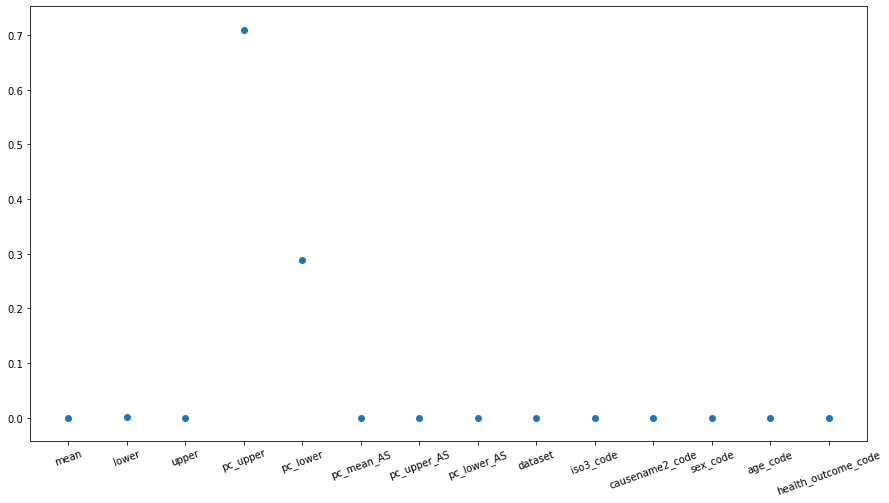

In [37]:
plt.figure(figsize=(15,8))
plt.scatter(list(df_norm_random.columns)[:3] + list(df_norm_random.columns)[4:], rforest.feature_importances_)
plt.xticks(rotation=20)

In [40]:
lin_reg = LinearRegression()
lin_reg.fit(df_norm_linear.drop('pc_mean', axis=1), df_norm_linear['pc_mean'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
features = list(df_norm_linear.columns)[:3] + list(df_norm_linear.columns)[4:]
idxs = abs(lin_reg.coef_.ravel()).argsort()

In [47]:
idxs[::-1]

array([171, 170, 156, 167,   8, 157, 166, 168, 169, 158, 159, 161, 160,
       162, 165, 163, 164,  84,  60,  21,  93,  65, 129, 114,  49, 145,
       115,  41, 124,  42,  11,  27,  54,  90, 134,  22,  13,  55,  78,
        57, 128, 135, 119, 111,  14, 137,  81,  96, 140, 146,  31,  71,
        16,  97, 141,  48,  59,  32, 131,  43,  19,  82,  30,  26, 116,
       147,  69,  50,  73,  36,  20, 127,  80,  75,  40,  68, 102, 108,
        92,  18,  45, 149,  95,  94, 122,  85,  86,  25,  56,  15,  44,
       107,  61, 143,  77, 125,  87,  63,  53,  37,  89, 138,  39,  62,
        23,  38,  46,  17, 100,  98, 103, 132,  34,  91, 148,  66,  29,
        51, 155, 153, 133,  72,  67, 106,  70, 142,  76, 118,  28,  64,
        33, 105,  74, 112,  99,  58, 104,  12,  83,  35, 121, 144,  79,
       101, 151, 154,  24,  47, 136, 139, 117,  88, 110, 150, 109, 130,
       126, 120, 113,   9,  52, 152,  10, 123,   5,   3,   6,   4,   7,
         0,   2,   1])

In [50]:
for i in idxs[::-1][:50]:
    print("{} : {}".format(features[i], lin_reg.coef_.ravel()[i]))

health_outcome_dths : 12787190738.425741
health_outcome_daly : 12787190738.425707
causename2_ALRI : -7986536077.578402
age_25+ : -6904935338.290678
dataset : 3306689203.6620746
causename2_All diseases : -2710021880.7518377
age_0 : 2648120427.772895
age_All ages (ALRI) : 2648120427.7728815
age_All ages (AP) : -2628393769.053767
causename2_COPD : 1566519688.4851828
causename2_Cataract : 1566519688.48518
causename2_Lung cancer : 1566519688.4851425
causename2_IHD : 1566519688.48514
causename2_Stroke : 1566519688.4850307
sex_m : 133301648.92563343
sex_b : 133301648.92562199
sex_f : 133301648.92560053
iso3_LVA : -52212063.77280083
iso3_GRC : -52212063.77274718
iso3_BGR : -52212063.77267421
iso3_MNE : -52212063.77266628
iso3_HRV : -52212063.772649705
iso3_SVN : -52212063.772626296
iso3_ROU : -52212063.77261506
iso3_EST : -52212063.77260626
iso3_URY : -52212063.77258067
iso3_RUS : -52212063.77255759
iso3_CUB : -52212063.7725465
iso3_SRB : -52212063.77252501
iso3_CZE : -52212063.77251826
iso3_A

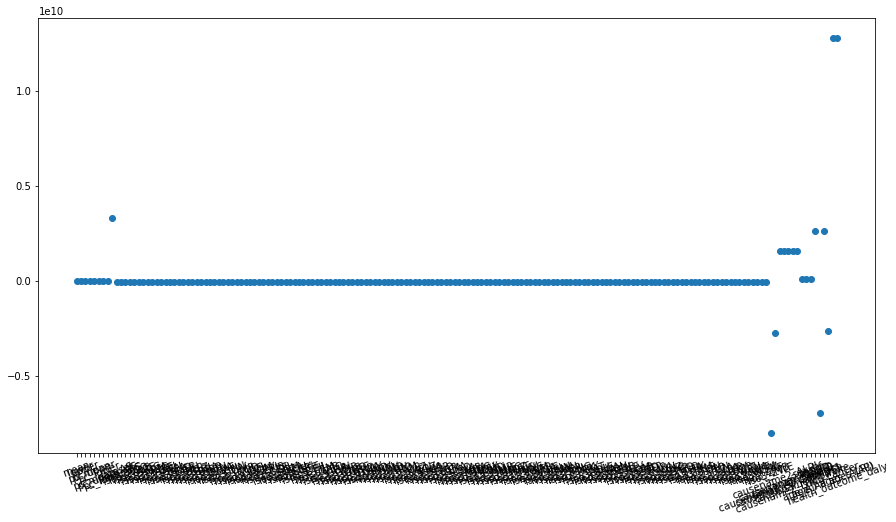

In [51]:
plt.figure(figsize=(15,8))
plt.scatter(df_norm_linear.columns[:-1], lin_reg.coef_.ravel())
plt.xticks(rotation=20);

In [52]:
air_polution = pd.read_csv('../resources/pm10.csv')

In [53]:
air_polution

,iso3,pm10,year
0,ALB,25.000000,2014.666667
1,AND,19.000000,2017.000000
2,ARE,141.500000,2014.000000
3,ARG,27.000000,2016.000000
4,AUS,17.090909,2015.696970
5,AUT,17.377193,2015.631579
6,BEL,20.596491,2015.526316
7,BGD,134.875000,2014.875000
8,BGR,38.000000,2015.184211
9,BHR,249.400000,2012.000000


In [55]:
np.intersect1d(ambient_data.iso3, air_polution.iso3)

array(['ALB', 'AND', 'ARE', 'ARG', 'AUS', 'AUT', 'BEL', 'BGD', 'BGR',
       'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BTN', 'CAN', 'CHE', 'CHL',
       'CHN', 'CMR', 'COL', 'CRI', 'CYP', 'CZE', 'DEU', 'DNK', 'ECU',
       'EGY', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GHA', 'GRC',
       'GTM', 'HND', 'HRV', 'HUN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL',
       'ISR', 'ITA', 'JAM', 'JOR', 'KOR', 'KWT', 'LBN', 'LBR', 'LKA',
       'LTU', 'LUX', 'LVA', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MKD',
       'MLT', 'MMR', 'MNE', 'MNG', 'MUS', 'MYS', 'NLD', 'NOR', 'NZL',
       'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRT', 'ROU', 'RUS',
       'SAU', 'SEN', 'SGP', 'SRB', 'SVK', 'SVN', 'SWE', 'THA', 'TUN',
       'TUR', 'TZA', 'UGA', 'UKR', 'URY', 'VEN', 'VNM', 'ZAF'],
      dtype=object)